# ÁÆÄÂçï Encoder Transformer Êû∂ÊûÑÂÆûÁé∞

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

print(f"PyTorchÁâàÊú¨: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

PyTorchÁâàÊú¨: 2.8.0
‰ΩøÁî®ËÆæÂ§á: cpu


In [11]:
class MultiHeadAttention(nn.Module):
    """Â§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂ÂÆûÁé∞"""
    
    def __init__(self, d_model, n_heads, dropout=0.1, debug=False):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.debug = debug
        
        # Á∫øÊÄßÂèòÊç¢Â±Ç
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None  # Áî®‰∫éÂ≠òÂÇ®Ê≥®ÊÑèÂäõÊùÉÈáç
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        if self.debug:
            print(f"MultiHeadAttention ËæìÂÖ•ÂΩ¢Áä∂:")
            print(f"  Query: {query.shape}")
            print(f"  Key: {key.shape}")
            print(f"  Value: {value.shape}")
        
        # 1. Á∫øÊÄßÂèòÊç¢Âπ∂ÂàÜÂ§¥
        # [batch_size, seq_len, d_model] -> [batch_size, n_heads, seq_len, d_k]
        Q = self.W_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        if self.debug:
            print(f"  ÂàÜÂ§¥Âêé Q: {Q.shape}")
            print(f"  ÂàÜÂ§¥Âêé K: {K.shape}")
            print(f"  ÂàÜÂ§¥Âêé V: {V.shape}")
        
        # 2. ËÆ°ÁÆóÁº©ÊîæÁÇπÁßØÊ≥®ÊÑèÂäõ
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        
        # ‰øùÂ≠òÊ≥®ÊÑèÂäõÊùÉÈáçÁî®‰∫éÂèØËßÜÂåñ
        self.attention_weights = attention.detach().cpu()
        
        # 3. Â∫îÁî®Ê≥®ÊÑèÂäõÊùÉÈáç
        context = torch.matmul(attention, V)
        
        # 4. ÊãºÊé•Â§öÂ§¥
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        # 5. ÊúÄÂêéÁöÑÁ∫øÊÄßÂèòÊç¢
        output = self.W_o(context)
        
        if self.debug:
            print(f"  ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
            print(f"  Ê≥®ÊÑèÂäõÊùÉÈáçÂΩ¢Áä∂: {attention.shape}")
        
        return output
    
    def get_attention_weights(self):
        """Ëé∑ÂèñÊúÄÂêé‰∏ÄÊ¨°ÂâçÂêë‰º†Êí≠ÁöÑÊ≥®ÊÑèÂäõÊùÉÈáç"""
        return self.attention_weights

# ÊµãËØï Multi-Head Attention
print("ÊµãËØï Multi-Head Attention:")
print("-" * 50)
mha = MultiHeadAttention(d_model=512, n_heads=8, debug=True)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = mha(x, x, x)
print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {output.shape}")

ÊµãËØï Multi-Head Attention:
--------------------------------------------------
MultiHeadAttention ËæìÂÖ•ÂΩ¢Áä∂:
  Query: torch.Size([2, 10, 512])
  Key: torch.Size([2, 10, 512])
  Value: torch.Size([2, 10, 512])
  ÂàÜÂ§¥Âêé Q: torch.Size([2, 8, 10, 64])
  ÂàÜÂ§¥Âêé K: torch.Size([2, 8, 10, 64])
  ÂàÜÂ§¥Âêé V: torch.Size([2, 8, 10, 64])
  ËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])
  Ê≥®ÊÑèÂäõÊùÉÈáçÂΩ¢Áä∂: torch.Size([2, 8, 10, 10])
ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])


In [4]:
class PositionalEncoding(nn.Module):
    """‰ΩçÁΩÆÁºñÁ†ÅÂÆûÁé∞ (‰ΩøÁî®Ê≠£Âº¶/‰ΩôÂº¶ÂáΩÊï∞)"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1, debug=False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.debug = debug
        
        # ÂàõÂª∫‰ΩçÁΩÆÁºñÁ†ÅÁü©Èòµ
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # ÂàõÂª∫È¢ëÁéáÂàÜÈáè
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        # Â∫îÁî®Ê≠£Âº¶Âíå‰ΩôÂº¶ÂáΩÊï∞
        pe[:, 0::2] = torch.sin(position * div_term)  # ÂÅ∂Êï∞‰ΩçÁΩÆ
        pe[:, 1::2] = torch.cos(position * div_term)  # Â•áÊï∞‰ΩçÁΩÆ
        
        # Ê∑ªÂä†ÊâπÊ¨°Áª¥Â∫¶Âπ∂Ê≥®ÂÜå‰∏∫ÁºìÂÜ≤Âå∫
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        if self.debug:
            print(f"‰ΩçÁΩÆÁºñÁ†ÅÁü©ÈòµÂΩ¢Áä∂: {pe.shape}")
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        if self.debug:
            print(f"PositionalEncoding ËæìÂÖ•ÂΩ¢Áä∂: {x.shape}")
            print(f"Ê∑ªÂä†ÁöÑ‰ΩçÁΩÆÁºñÁ†ÅÂΩ¢Áä∂: {self.pe[:x.size(0)].shape}")
        
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# ÂèØÈÄâÔºöÂèØÂ≠¶‰π†ÁöÑ‰ΩçÁΩÆÂµåÂÖ•
class LearnablePositionalEncoding(nn.Module):
    """ÂèØÂ≠¶‰π†ÁöÑ‰ΩçÁΩÆÁºñÁ†Å"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        x = x + self.pos_embedding(positions)
        return self.dropout(x)

# ÊµãËØï‰ΩçÁΩÆÁºñÁ†Å
print("\nÊµãËØï‰ΩçÁΩÆÁºñÁ†Å:")
print("-" * 50)
pe = PositionalEncoding(d_model=512, debug=True)
x = torch.randn(10, 2, 512)  # [seq_len, batch_size, d_model]
output = pe(x)
print(f"ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")

# ÂèØËßÜÂåñ‰ΩçÁΩÆÁºñÁ†Å
def visualize_positional_encoding(d_model=128, max_len=100):
    pe = PositionalEncoding(d_model, max_len)
    encoding = pe.pe[:max_len, 0, :].numpy()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(encoding, cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.title('‰ΩçÁΩÆÁºñÁ†ÅÁÉ≠Âõæ')
    
    # ÊòæÁ§∫ÂâçÂá†‰∏™Áª¥Â∫¶ÁöÑÁºñÁ†ÅÊõ≤Á∫ø
    plt.subplot(1, 2, 2)
    for i in range(4):
        plt.plot(encoding[:, i], label=f'dim {i}')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('Ââç4‰∏™Áª¥Â∫¶ÁöÑ‰ΩçÁΩÆÁºñÁ†Å')
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_positional_encoding()


ÊµãËØï‰ΩçÁΩÆÁºñÁ†Å:
--------------------------------------------------
‰ΩçÁΩÆÁºñÁ†ÅÁü©ÈòµÂΩ¢Áä∂: torch.Size([5000, 1, 512])
PositionalEncoding ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([10, 2, 512])
Ê∑ªÂä†ÁöÑ‰ΩçÁΩÆÁºñÁ†ÅÂΩ¢Áä∂: torch.Size([10, 1, 512])
ËæìÂá∫ÂΩ¢Áä∂: torch.Size([10, 2, 512])


/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz

In [5]:
class FeedForwardNetwork(nn.Module):
    """ÂâçÈ¶àÁΩëÁªú (Position-wise Feed-Forward Network)"""
    
    def __init__(self, d_model, d_ff, dropout=0.1, activation='relu', debug=False):
        super(FeedForwardNetwork, self).__init__()
        self.debug = debug
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # ÈÄâÊã©ÊøÄÊ¥ªÂáΩÊï∞
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        if self.debug:
            print(f"FFN ËæìÂÖ•ÂΩ¢Áä∂: {x.shape}")
        
        # Á¨¨‰∏ÄÂ±ÇÁ∫øÊÄßÂèòÊç¢ + ÊøÄÊ¥ª
        hidden = self.linear1(x)
        hidden = self.activation(hidden)
        hidden = self.dropout(hidden)
        
        # Á¨¨‰∫åÂ±ÇÁ∫øÊÄßÂèòÊç¢
        output = self.linear2(hidden)
        output = self.dropout(output)
        
        if self.debug:
            print(f"FFN ‰∏≠Èó¥Â±ÇÂΩ¢Áä∂: {hidden.shape}")
            print(f"FFN ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        
        return output

# ÊµãËØïÂâçÈ¶àÁΩëÁªú
print("\nÊµãËØïÂâçÈ¶àÁΩëÁªú:")
print("-" * 50)
ffn = FeedForwardNetwork(d_model=512, d_ff=2048, activation='gelu', debug=True)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = ffn(x)
print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {output.shape}")


ÊµãËØïÂâçÈ¶àÁΩëÁªú:
--------------------------------------------------
FFN ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 10, 512])
FFN ‰∏≠Èó¥Â±ÇÂΩ¢Áä∂: torch.Size([2, 10, 2048])
FFN ËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])
ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])


In [6]:
class EncoderLayer(nn.Module):
    """Transformer Encoder Â±Ç"""
    
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, activation='gelu', debug=False):
        super(EncoderLayer, self).__init__()
        self.debug = debug
        
        # Â≠êÂ±Ç
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout, debug=False)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff, dropout, activation, debug=False)
        
        # Â±ÇÂΩí‰∏ÄÂåñ
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
            mask: ÂèØÈÄâÁöÑÊé©Á†ÅÂº†Èáè
        """
        if self.debug:
            print(f"EncoderLayer ËæìÂÖ•ÂΩ¢Áä∂: {x.shape}")
        
        # 1. Â§öÂ§¥Ëá™Ê≥®ÊÑèÂäõ + ÊÆãÂ∑ÆËøûÊé• + Â±ÇÂΩí‰∏ÄÂåñ
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        if self.debug:
            print(f"Ê≥®ÊÑèÂäõÂêéÂΩ¢Áä∂: {x.shape}")
        
        # 2. ÂâçÈ¶àÁΩëÁªú + ÊÆãÂ∑ÆËøûÊé• + Â±ÇÂΩí‰∏ÄÂåñ
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        if self.debug:
            print(f"EncoderLayer ËæìÂá∫ÂΩ¢Áä∂: {x.shape}")
        
        return x
    
    def get_attention_weights(self):
        """Ëé∑ÂèñÊ≥®ÊÑèÂäõÊùÉÈáç"""
        return self.self_attn.get_attention_weights()

# ÊµãËØï Encoder Layer
print("\nÊµãËØï Encoder Layer:")
print("-" * 50)
encoder_layer = EncoderLayer(
    d_model=512, 
    n_heads=8, 
    d_ff=2048, 
    dropout=0.1,
    activation='gelu',
    debug=True
)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = encoder_layer(x)
print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {output.shape}")

# Ê£ÄÊü•Ê≥®ÊÑèÂäõÊùÉÈáç
attn_weights = encoder_layer.get_attention_weights()
print(f"Ê≥®ÊÑèÂäõÊùÉÈáçÂΩ¢Áä∂: {attn_weights.shape}")  # [batch_size, n_heads, seq_len, seq_len]


ÊµãËØï Encoder Layer:
--------------------------------------------------
EncoderLayer ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 10, 512])
Ê≥®ÊÑèÂäõÂêéÂΩ¢Áä∂: torch.Size([2, 10, 512])
EncoderLayer ËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])
ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 10, 512])
Ê≥®ÊÑèÂäõÊùÉÈáçÂΩ¢Áä∂: torch.Size([2, 8, 10, 10])


In [7]:
class TransformerEncoder(nn.Module):
    """ÂÆåÊï¥ÁöÑ Transformer Encoder"""
    
    def __init__(self, 
                 vocab_size,
                 d_model=512,
                 n_heads=8,
                 n_layers=6,
                 d_ff=2048,
                 max_len=5000,
                 dropout=0.1,
                 activation='gelu',
                 use_learnable_pos_encoding=False,
                 debug=False):
        super(TransformerEncoder, self).__init__()
        self.debug = debug
        self.d_model = d_model
        
        # ËæìÂÖ•ÂµåÂÖ•Â±Ç
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.scale = math.sqrt(d_model)  # Áº©ÊîæÂõ†Â≠ê
        
        # ‰ΩçÁΩÆÁºñÁ†Å
        if use_learnable_pos_encoding:
            self.pos_encoding = LearnablePositionalEncoding(d_model, max_len, dropout)
        else:
            self.pos_encoding = PositionalEncoding(d_model, max_len, dropout, debug=False)
        
        # Encoder Â±ÇÂ†ÜÂè†
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout, activation, debug=False)
            for _ in range(n_layers)
        ])
        
        # ÊúÄÂêéÁöÑÂ±ÇÂΩí‰∏ÄÂåñ
        self.norm = nn.LayerNorm(d_model)
        
        # ÂàùÂßãÂåñÂèÇÊï∞
        self._init_parameters()
        
    def _init_parameters(self):
        """ÂàùÂßãÂåñÊ®°ÂûãÂèÇÊï∞"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, mask=None):
        """
        Args:
            src: ËæìÂÖ•Â∫èÂàóÁöÑÁ¥¢Âºï [batch_size, seq_len]
            mask: ÂèØÈÄâÁöÑÊé©Á†ÅÂº†Èáè
        Returns:
            output: [batch_size, seq_len, d_model]
        """
        if self.debug:
            print(f"TransformerEncoder ËæìÂÖ•ÂΩ¢Áä∂: {src.shape}")
        
        # ÂµåÂÖ•Âπ∂Áº©Êîæ
        x = self.embedding(src) * self.scale
        
        if self.debug:
            print(f"ÂµåÂÖ•ÂêéÂΩ¢Áä∂: {x.shape}")
        
        # Ê∑ªÂä†‰ΩçÁΩÆÁºñÁ†Å
        # ÈúÄË¶ÅËΩ¨Êç¢‰∏∫ [seq_len, batch_size, d_model] Ê†ºÂºè
        x = x.transpose(0, 1)
        x = self.pos_encoding(x)
        # ËΩ¨Êç¢Âõû [batch_size, seq_len, d_model]
        x = x.transpose(0, 1)
        
        if self.debug:
            print(f"‰ΩçÁΩÆÁºñÁ†ÅÂêéÂΩ¢Áä∂: {x.shape}")
        
        # ÈÄöËøáÊâÄÊúâ Encoder Â±Ç
        for i, layer in enumerate(self.layers):
            x = layer(x, mask)
            if self.debug and i == 0:
                print(f"Á¨¨‰∏ÄÂ±ÇÂêéÂΩ¢Áä∂: {x.shape}")
        
        # ÊúÄÂêéÁöÑÂ±ÇÂΩí‰∏ÄÂåñ
        x = self.norm(x)
        
        if self.debug:
            print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {x.shape}")
        
        return x
    
    def get_attention_weights_all_layers(self):
        """Ëé∑ÂèñÊâÄÊúâÂ±ÇÁöÑÊ≥®ÊÑèÂäõÊùÉÈáç"""
        weights = []
        for layer in self.layers:
            weights.append(layer.get_attention_weights())
        return weights

# ÊµãËØïÂÆåÊï¥ÁöÑ Encoder
print("\nÊµãËØïÂÆåÊï¥ÁöÑ Transformer Encoder:")
print("-" * 50)

# ÂàõÂª∫Ê®°Âûã
vocab_size = 10000
encoder = TransformerEncoder(
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    n_layers=6,
    d_ff=2048,
    max_len=1000,
    dropout=0.1,
    activation='gelu',
    debug=True
)

# ÂàõÂª∫ËæìÂÖ• (ÊâπÊ¨°Â§ßÂ∞è=2, Â∫èÂàóÈïøÂ∫¶=20)
src = torch.randint(0, vocab_size, (2, 20))
print(f"ËæìÂÖ• token IDs ÂΩ¢Áä∂: {src.shape}")

# ÂâçÂêë‰º†Êí≠
output = encoder(src)
print(f"\nÁºñÁ†ÅÂô®ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")

# ËÆ°ÁÆóÂèÇÊï∞Èáè
total_params = sum(p.numel() for p in encoder.parameters())
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"\nÊ®°ÂûãÂèÇÊï∞Èáè:")
print(f"  ÊÄªÂèÇÊï∞: {total_params:,}")
print(f"  ÂèØËÆ≠ÁªÉÂèÇÊï∞: {trainable_params:,}")


ÊµãËØïÂÆåÊï¥ÁöÑ Transformer Encoder:
--------------------------------------------------
ËæìÂÖ• token IDs ÂΩ¢Áä∂: torch.Size([2, 20])
TransformerEncoder ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 20])
ÂµåÂÖ•ÂêéÂΩ¢Áä∂: torch.Size([2, 20, 512])
‰ΩçÁΩÆÁºñÁ†ÅÂêéÂΩ¢Áä∂: torch.Size([2, 20, 512])
Á¨¨‰∏ÄÂ±ÇÂêéÂΩ¢Áä∂: torch.Size([2, 20, 512])
ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 20, 512])

ÁºñÁ†ÅÂô®ËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 20, 512])

Ê®°ÂûãÂèÇÊï∞Èáè:
  ÊÄªÂèÇÊï∞: 24,035,328
  ÂèØËÆ≠ÁªÉÂèÇÊï∞: 24,035,328


In [8]:
# Ë∞ÉËØïÂíåÂèØËßÜÂåñÂäüËÉΩ

def visualize_attention_weights(encoder, src, layer_idx=0, head_idx=0):
    """ÂèØËßÜÂåñÊ≥®ÊÑèÂäõÊùÉÈáç"""
    # ÂâçÂêë‰º†Êí≠
    with torch.no_grad():
        _ = encoder(src)
    
    # Ëé∑ÂèñÊâÄÊúâÂ±ÇÁöÑÊ≥®ÊÑèÂäõÊùÉÈáç
    all_weights = encoder.get_attention_weights_all_layers()
    
    if layer_idx >= len(all_weights):
        print(f"Layer {layer_idx} ‰∏çÂ≠òÂú®ÔºåÊ®°ÂûãÂè™Êúâ {len(all_weights)} Â±Ç")
        return
    
    # Ëé∑ÂèñÊåáÂÆöÂ±ÇÁöÑÊùÉÈáç [batch_size, n_heads, seq_len, seq_len]
    layer_weights = all_weights[layer_idx]
    
    # ÈÄâÊã©Á¨¨‰∏Ä‰∏™Ê†∑Êú¨ÂíåÊåáÂÆöÁöÑÂ§¥
    attention = layer_weights[0, head_idx].numpy()
    
    # ÂàõÂª∫ÂèØËßÜÂåñ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ÁÉ≠Âõæ
    im1 = ax1.imshow(attention, cmap='Blues', aspect='auto')
    ax1.set_xlabel('Key Position')
    ax1.set_ylabel('Query Position')
    ax1.set_title(f'Layer {layer_idx}, Head {head_idx} - Attention Weights')
    plt.colorbar(im1, ax=ax1)
    
    # Âπ≥ÂùáÊ≥®ÊÑèÂäõÂàÜÂ∏É
    avg_attention = attention.mean(axis=0)
    ax2.bar(range(len(avg_attention)), avg_attention)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Average Attention')
    ax2.set_title('Average Attention Distribution')
    
    plt.tight_layout()
    plt.show()

def check_gradient_flow(model):
    """Ê£ÄÊü•Ê¢ØÂ∫¶ÊµÅ"""
    # ÂàõÂª∫ËôöÊãüËæìÂÖ•ÂíåÁõÆÊ†á
    batch_size, seq_len = 2, 10
    vocab_size = 10000
    src = torch.randint(0, vocab_size, (batch_size, seq_len))
    
    # ÂâçÂêë‰º†Êí≠
    output = model(src)
    
    # ÂàõÂª∫ËôöÊãüÊçüÂ§±
    loss = output.mean()
    
    # ÂèçÂêë‰º†Êí≠
    loss.backward()
    
    # Ê£ÄÊü•Ê¢ØÂ∫¶
    gradient_info = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            gradient_info.append({
                'name': name,
                'shape': list(param.shape),
                'grad_norm': grad_norm,
                'has_nan': torch.isnan(param.grad).any().item(),
                'has_inf': torch.isinf(param.grad).any().item()
            })
    
    # ÊâìÂç∞Ê¢ØÂ∫¶‰ø°ÊÅØ
    print("\nÊ¢ØÂ∫¶ÊµÅÊ£ÄÊü•:")
    print("-" * 80)
    print(f"{'Layer Name':<50} {'Shape':<20} {'Grad Norm':<15} {'Status'}")
    print("-" * 80)
    
    for info in gradient_info[:10]:  # Âè™ÊòæÁ§∫Ââç10‰∏™
        status = "OK"
        if info['has_nan']:
            status = "NaN!"
        elif info['has_inf']:
            status = "Inf!"
        elif info['grad_norm'] == 0:
            status = "Zero!"
        elif info['grad_norm'] > 100:
            status = "Large!"
        
        print(f"{info['name']:<50} {str(info['shape']):<20} {info['grad_norm']:<15.6f} {status}")
    
    return gradient_info

def profile_model(model, input_shape=(2, 20)):
    """ÂàÜÊûêÊ®°ÂûãÊÄßËÉΩ"""
    import time
    
    vocab_size = 10000
    src = torch.randint(0, vocab_size, input_shape).to(device)
    model = model.to(device)
    model.eval()
    
    # È¢ÑÁÉ≠
    with torch.no_grad():
        for _ in range(10):
            _ = model(src)
    
    # ËÆ°Êó∂
    times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            _ = model(src)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append(time.time() - start)
    
    times = np.array(times[10:])  # ÂéªÊéâÂâç10Ê¨°
    
    print("\nÊÄßËÉΩÂàÜÊûê:")
    print("-" * 50)
    print(f"ËÆæÂ§á: {device}")
    print(f"ËæìÂÖ•ÂΩ¢Áä∂: {input_shape}")
    print(f"Âπ≥ÂùáÊé®ÁêÜÊó∂Èó¥: {times.mean()*1000:.2f} ms")
    print(f"Ê†áÂáÜÂ∑Æ: {times.std()*1000:.2f} ms")
    print(f"ÊúÄÂ∞èÊó∂Èó¥: {times.min()*1000:.2f} ms")
    print(f"ÊúÄÂ§ßÊó∂Èó¥: {times.max()*1000:.2f} ms")
    
    # ËÆ°ÁÆóÂêûÂêêÈáè
    batch_size, seq_len = input_shape
    throughput = batch_size * seq_len / times.mean()
    print(f"ÂêûÂêêÈáè: {throughput:.0f} tokens/Áßí")

# ÊµãËØïÂèØËßÜÂåñ
print("\nÊµãËØïÊ≥®ÊÑèÂäõÊùÉÈáçÂèØËßÜÂåñ:")
print("-" * 50)
src = torch.randint(0, vocab_size, (1, 15))
visualize_attention_weights(encoder, src, layer_idx=0, head_idx=0)

# ÊµãËØïÊ¢ØÂ∫¶ÊµÅ
print("\nÊµãËØïÊ¢ØÂ∫¶ÊµÅ:")
encoder_test = TransformerEncoder(
    vocab_size=10000,
    d_model=256,
    n_heads=4,
    n_layers=3,
    d_ff=1024
)
gradient_info = check_gradient_flow(encoder_test)

# ÊµãËØïÊÄßËÉΩ
print("\nÊµãËØïÊÄßËÉΩ:")
profile_model(encoder, input_shape=(4, 50))


ÊµãËØïÊ≥®ÊÑèÂäõÊùÉÈáçÂèØËßÜÂåñ:
--------------------------------------------------
TransformerEncoder ËæìÂÖ•ÂΩ¢Áä∂: torch.Size([1, 15])
ÂµåÂÖ•ÂêéÂΩ¢Áä∂: torch.Size([1, 15, 512])
‰ΩçÁΩÆÁºñÁ†ÅÂêéÂΩ¢Áä∂: torch.Size([1, 15, 512])
Á¨¨‰∏ÄÂ±ÇÂêéÂΩ¢Áä∂: torch.Size([1, 15, 512])
ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: torch.Size([1, 15, 512])



ÊµãËØïÊ¢ØÂ∫¶ÊµÅ:

Ê¢ØÂ∫¶ÊµÅÊ£ÄÊü•:
--------------------------------------------------------------------------------
Layer Name                                         Shape                Grad Norm       Status
--------------------------------------------------------------------------------
embedding.weight                                   [10000, 256]         0.000000        OK
layers.0.self_attn.W_q.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_q.bias                        [256]                0.000000        OK
layers.0.self_attn.W_k.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_k.bias                        [256]                0.000000        OK
layers.0.self_attn.W_v.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_v.bias                        [256]                0.000000        OK
layers.0.self_attn.W_o.weight                      [256, 256]         


ÊµãËØïÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°:

ÁîüÊàêÂêàÊàêÊï∞ÊçÆÈõÜ...
ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: 500
Â∫èÂàóÈïøÂ∫¶: 15
Á±ªÂà´Êï∞: 3

ÂºÄÂßãËÆ≠ÁªÉ...
Epoch [2/10], Loss: 1.1096, Accuracy: 0.3540
Epoch [4/10], Loss: 0.4396, Accuracy: 0.8320
Epoch [6/10], Loss: 0.1533, Accuracy: 0.9340
Epoch [8/10], Loss: 0.0426, Accuracy: 0.9920
Epoch [10/10], Loss: 0.0098, Accuracy: 0.9980


/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm

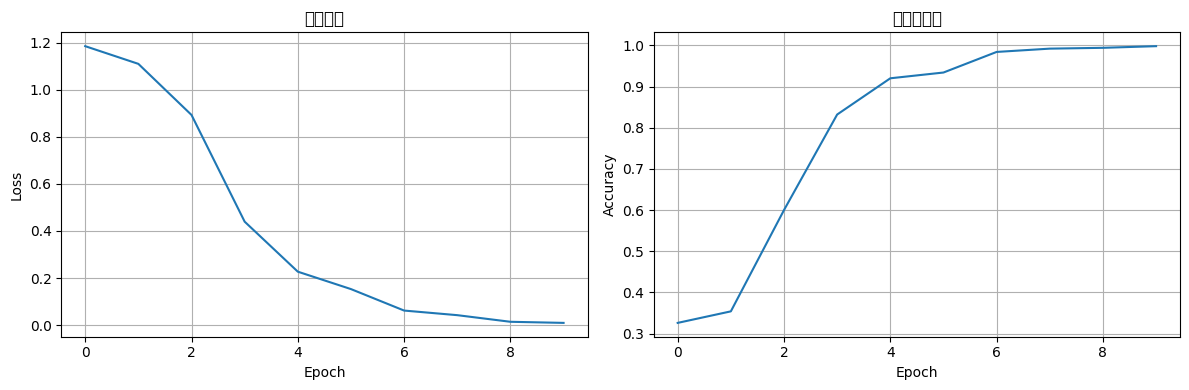


‚úÖ ÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°ÊµãËØïÂÆåÊàêÔºÅ


In [9]:
# ÁÆÄÂçïÁöÑÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°Á§∫‰æã

class TextClassifier(nn.Module):
    """Âü∫‰∫é Transformer Encoder ÁöÑÊñáÊú¨ÂàÜÁ±ªÂô®"""
    
    def __init__(self, encoder, num_classes):
        super(TextClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.d_model, num_classes)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, mask=None):
        # Ëé∑ÂèñÁºñÁ†ÅÂô®ËæìÂá∫
        encoder_output = self.encoder(x, mask)  # [batch_size, seq_len, d_model]
        
        # ‰ΩøÁî®Âπ≥ÂùáÊ±†ÂåñËé∑ÂèñÂè•Â≠êË°®Á§∫
        sentence_repr = encoder_output.mean(dim=1)  # [batch_size, d_model]
        
        # ÂàÜÁ±ª
        sentence_repr = self.dropout(sentence_repr)
        logits = self.classifier(sentence_repr)
        
        return logits

# ÂàõÂª∫‰∏Ä‰∏™ÁÆÄÂçïÁöÑÂêàÊàêÊï∞ÊçÆÈõÜËøõË°åÊµãËØï
def create_synthetic_dataset(num_samples=1000, seq_len=20, vocab_size=1000, num_classes=3):
    """ÂàõÂª∫ÂêàÊàêÊï∞ÊçÆÈõÜ"""
    # ÈöèÊú∫ÁîüÊàêËæìÂÖ•Â∫èÂàó
    X = torch.randint(0, vocab_size, (num_samples, seq_len))
    
    # ÁÆÄÂçïËßÑÂàôÔºöÂü∫‰∫éÂ∫èÂàó‰∏≠Êüê‰∫õÁâπÂÆö token ÁöÑÂá∫Áé∞Êù•ÂàÜÁ±ª
    y = []
    for seq in X:
        # ËßÑÂàôÔºöÂ¶ÇÊûúÂ∫èÂàóÂâç3‰∏™tokenÁöÑÂíåÊ®°3Á≠â‰∫éÁ±ªÂà´
        label = seq[:3].sum().item() % num_classes
        y.append(label)
    
    y = torch.tensor(y)
    
    return X, y

# ËÆ≠ÁªÉÂáΩÊï∞
def train_classifier(model, train_X, train_y, epochs=10, batch_size=32, lr=0.001):
    """ËÆ≠ÁªÉÂàÜÁ±ªÂô®"""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    num_samples = len(train_X)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        # Êâì‰π±Êï∞ÊçÆ
        indices = torch.randperm(num_samples)
        train_X = train_X[indices]
        train_y = train_y[indices]
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            
            batch_X = train_X[start_idx:end_idx].to(device)
            batch_y = train_y[start_idx:end_idx].to(device)
            
            # ÂâçÂêë‰º†Êí≠
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            
            # ÂèçÂêë‰º†Êí≠
            optimizer.zero_grad()
            loss.backward()
            
            # Ê¢ØÂ∫¶Ë£ÅÂâ™
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # ÁªüËÆ°
            epoch_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
        avg_loss = epoch_loss / num_batches
        accuracy = correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return losses, accuracies

# ÊµãËØïÂÆåÊï¥ÁöÑÊñáÊú¨ÂàÜÁ±ªÊµÅÁ®ã
print("\nÊµãËØïÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°:")
print("=" * 60)

# ÂàõÂª∫Â∞èÂûãÁºñÁ†ÅÂô®Áî®‰∫éÊµãËØï
small_encoder = TransformerEncoder(
    vocab_size=1000,
    d_model=128,
    n_heads=4,
    n_layers=2,
    d_ff=512,
    dropout=0.1
).to(device)

# ÂàõÂª∫ÂàÜÁ±ªÂô®
num_classes = 3
classifier = TextClassifier(small_encoder, num_classes).to(device)

# ÂàõÂª∫Êï∞ÊçÆÈõÜ
print("\nÁîüÊàêÂêàÊàêÊï∞ÊçÆÈõÜ...")
train_X, train_y = create_synthetic_dataset(
    num_samples=500,
    seq_len=15,
    vocab_size=1000,
    num_classes=num_classes
)

print(f"ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: {len(train_X)}")
print(f"Â∫èÂàóÈïøÂ∫¶: {train_X.shape[1]}")
print(f"Á±ªÂà´Êï∞: {num_classes}")

# ËÆ≠ÁªÉÊ®°Âûã
print("\nÂºÄÂßãËÆ≠ÁªÉ...")
losses, accuracies = train_classifier(
    classifier,
    train_X,
    train_y,
    epochs=10,
    batch_size=32,
    lr=0.001
)

# ÂèØËßÜÂåñËÆ≠ÁªÉËøáÁ®ã
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ËÆ≠ÁªÉÊçüÂ§±')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ËÆ≠ÁªÉÂáÜÁ°ÆÁéá')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n‚úÖ ÊñáÊú¨ÂàÜÁ±ª‰ªªÂä°ÊµãËØïÂÆåÊàêÔºÅ")

In [10]:
# Ë∞ÉËØïÂ∑•ÂÖ∑ÊÄªÁªì

print("=" * 80)
print("üéØ Transformer Encoder ÂÆûÁé∞ÂÆåÊàêÔºÅ")
print("=" * 80)

print("\nüìö Â∑≤ÂÆûÁé∞ÁöÑÁªÑ‰ª∂Ôºö")
print("1. ‚úÖ Multi-Head Attention - Â§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂")
print("2. ‚úÖ Positional Encoding - ‰ΩçÁΩÆÁºñÁ†ÅÔºàÊ≠£Âº¶/‰ΩôÂº¶ & ÂèØÂ≠¶‰π†Ôºâ")
print("3. ‚úÖ Feed-Forward Network - ÂâçÈ¶àÁΩëÁªú")
print("4. ‚úÖ Encoder Layer - ÁºñÁ†ÅÂô®Â±ÇÔºàÂê´ÊÆãÂ∑ÆËøûÊé•ÂíåÂ±ÇÂΩí‰∏ÄÂåñÔºâ")
print("5. ‚úÖ Transformer Encoder - ÂÆåÊï¥ÁºñÁ†ÅÂô®Â†ÜÊ†à")
print("6. ‚úÖ Text Classifier - ÊñáÊú¨ÂàÜÁ±ªÂô®Á§∫‰æã")

print("\nüõ†Ô∏è Ë∞ÉËØïÂäüËÉΩÔºö")
print("1. üìä ÂΩ¢Áä∂ÊâìÂç∞ - ÊØèÂ±ÇËæìÂÖ•ËæìÂá∫ÂΩ¢Áä∂")
print("2. üé® Ê≥®ÊÑèÂäõÂèØËßÜÂåñ - ÁÉ≠ÂõæÂíåÂàÜÂ∏ÉÂõæ")
print("3. üìà Ê¢ØÂ∫¶ÊµÅÊ£ÄÊü• - Ê£ÄÊµãÊ¢ØÂ∫¶Ê∂àÂ§±/ÁàÜÁÇ∏")
print("4. ‚ö° ÊÄßËÉΩÂàÜÊûê - Êé®ÁêÜÊó∂Èó¥ÂíåÂêûÂêêÈáè")
print("5. üìâ ËÆ≠ÁªÉÁõëÊéß - ÊçüÂ§±ÂíåÂáÜÁ°ÆÁéáÊõ≤Á∫ø")

print("\nüí° ‰ΩøÁî®ÊèêÁ§∫Ôºö")
print("‚Ä¢ ËÆæÁΩÆ debug=True Êù•Êü•ÁúãËØ¶ÁªÜÁöÑ‰∏≠Èó¥ËæìÂá∫")
print("‚Ä¢ ‰ΩøÁî® visualize_attention_weights() ÂèØËßÜÂåñÊ≥®ÊÑèÂäõÊ®°Âºè")
print("‚Ä¢ ‰ΩøÁî® check_gradient_flow() ËØäÊñ≠ËÆ≠ÁªÉÈóÆÈ¢ò")
print("‚Ä¢ ‰ΩøÁî® profile_model() ËØÑ‰º∞ÊÄßËÉΩ")

print("\nüìù ‰∏ã‰∏ÄÊ≠•ÂèØ‰ª•Â∞ùËØïÔºö")
print("‚Ä¢ Ê∑ªÂä† Decoder ÂÆûÁé∞ÂÆåÊï¥ÁöÑ Transformer")
print("‚Ä¢ ÂÆûÁé∞‰∏çÂêåÁöÑÊ≥®ÊÑèÂäõÊú∫Âà∂ÔºàÂ¶Ç Sparse AttentionÔºâ")
print("‚Ä¢ Ê∑ªÂä†Êõ¥Â§öÁöÑ‰ΩçÁΩÆÁºñÁ†ÅÊñπÂºèÔºàÂ¶Ç RoPEÔºâ")
print("‚Ä¢ Âú®ÁúüÂÆûÊï∞ÊçÆÈõÜ‰∏äËÆ≠ÁªÉÂíåËØÑ‰º∞")
print("‚Ä¢ ÂÆûÁé∞ beam search Á≠âËß£Á†ÅÁ≠ñÁï•")

print("\n‚ú® Happy Debugging! ‚ú®")

üéØ Transformer Encoder ÂÆûÁé∞ÂÆåÊàêÔºÅ

üìö Â∑≤ÂÆûÁé∞ÁöÑÁªÑ‰ª∂Ôºö
1. ‚úÖ Multi-Head Attention - Â§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂
2. ‚úÖ Positional Encoding - ‰ΩçÁΩÆÁºñÁ†ÅÔºàÊ≠£Âº¶/‰ΩôÂº¶ & ÂèØÂ≠¶‰π†Ôºâ
3. ‚úÖ Feed-Forward Network - ÂâçÈ¶àÁΩëÁªú
4. ‚úÖ Encoder Layer - ÁºñÁ†ÅÂô®Â±ÇÔºàÂê´ÊÆãÂ∑ÆËøûÊé•ÂíåÂ±ÇÂΩí‰∏ÄÂåñÔºâ
5. ‚úÖ Transformer Encoder - ÂÆåÊï¥ÁºñÁ†ÅÂô®Â†ÜÊ†à
6. ‚úÖ Text Classifier - ÊñáÊú¨ÂàÜÁ±ªÂô®Á§∫‰æã

üõ†Ô∏è Ë∞ÉËØïÂäüËÉΩÔºö
1. üìä ÂΩ¢Áä∂ÊâìÂç∞ - ÊØèÂ±ÇËæìÂÖ•ËæìÂá∫ÂΩ¢Áä∂
2. üé® Ê≥®ÊÑèÂäõÂèØËßÜÂåñ - ÁÉ≠ÂõæÂíåÂàÜÂ∏ÉÂõæ
3. üìà Ê¢ØÂ∫¶ÊµÅÊ£ÄÊü• - Ê£ÄÊµãÊ¢ØÂ∫¶Ê∂àÂ§±/ÁàÜÁÇ∏
4. ‚ö° ÊÄßËÉΩÂàÜÊûê - Êé®ÁêÜÊó∂Èó¥ÂíåÂêûÂêêÈáè
5. üìâ ËÆ≠ÁªÉÁõëÊéß - ÊçüÂ§±ÂíåÂáÜÁ°ÆÁéáÊõ≤Á∫ø

üí° ‰ΩøÁî®ÊèêÁ§∫Ôºö
‚Ä¢ ËÆæÁΩÆ debug=True Êù•Êü•ÁúãËØ¶ÁªÜÁöÑ‰∏≠Èó¥ËæìÂá∫
‚Ä¢ ‰ΩøÁî® visualize_attention_weights() ÂèØËßÜÂåñÊ≥®ÊÑèÂäõÊ®°Âºè
‚Ä¢ ‰ΩøÁî® check_gradient_flow() ËØäÊñ≠ËÆ≠ÁªÉÈóÆÈ¢ò
‚Ä¢ ‰ΩøÁî® profile_model() ËØÑ‰º∞ÊÄßËÉΩ

üìù ‰∏ã‰∏ÄÊ≠•ÂèØ‰ª•Â∞ùËØïÔºö
‚Ä¢ Ê∑ªÂä† Decoder ÂÆûÁé∞ÂÆåÊï¥ÁöÑ Transformer
‚Ä¢ ÂÆûÁé∞‰∏çÂ